# Toy data

In [1]:
import numpy as np
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
import matplotlib.pyplot as plt

In [21]:
def gen_data(n_samples, n_features, random_state=1):
    prng = np.random.RandomState(random_state)
    prec = make_sparse_spd_matrix(
        n_features, alpha=0.98, smallest_coef=0.4, largest_coef=0.7, random_state=prng
    )
    cov = linalg.inv(prec)
    d = np.sqrt(np.diag(cov))
    cov /= d
    cov /= d[:, np.newaxis]
    prec *= d
    prec *= d[:, np.newaxis]
    X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    X -= X.mean(axis=0)
    X /= X.std(axis=0)

    return cov, prec, X

def estimate_cov(X, n_samples):
    emp_cov = np.dot(X.T, X) / n_samples
    return emp_cov


def plot(precs):
    """plot the precisions

    Args:
        precs (_type_): _description_

    Examples:
        precs = [
            ("Empirical", linalg.inv(emp_cov)),
            ("Ledoit-Wolf", lw_prec_),
            ("GraphicalLasso", prec_),
            ("True", prec),
        ]
    """
    plt.figure(figsize=(10, 6))
    plt.subplots_adjust(left=0.02, right=0.98)
    
    for i, (name, this_prec) in enumerate(precs):
        ax = plt.subplot(2, 4, i + 5)
        plt.imshow(
            np.ma.masked_equal(this_prec, 0),
            interpolation="nearest",
            cmap=plt.cm.RdBu_r,
        )
        plt.xticks(())
        plt.yticks(())
        plt.title(name)
        if hasattr(ax, "set_facecolor"):
            ax.set_facecolor(".7")
        else:
            ax.set_axis_bgcolor(".7")

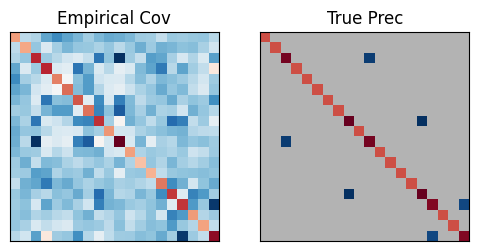

In [22]:
n_samples = 60
n_features = 20

cov, prec, X = gen_data(n_samples, n_features)
emp_cov = estimate_cov(X, n_samples)


plot([("Empirical Cov", linalg.inv(emp_cov)), ("True Prec", prec)])

# To jraph GraphTuple

In [9]:
import jax
import jax.numpy as jnp
import jraph

In [17]:
@jax.jit
def to_jraph_graphs_tuple(prec):
    edges, senders, revivers = [], [], []
    for i in range(prec.shape[0]):
        for j in range(prec.shape[1]):
            if i != j:
                edges.append(prec[i][j])
                senders.append(i)
                revivers.append(j)

    nodes = jnp.ones((prec.shape[0], 1))
    edges = jnp.array(edges).reshape(-1, 1)
    senders = jnp.array(senders)
    revivers = jnp.array(revivers)
    return jraph.GraphsTuple(
        nodes=nodes,
        edges=edges,
        senders=senders,
        receivers=revivers,
        n_node=jnp.array([prec.shape[0]]),
        n_edge=jnp.array([len(edges)]),
        globals=None
    )

noisy_graph = to_jraph_graphs_tuple(emp_cov)
real_graph = to_jraph_graphs_tuple(prec)

jraph.batch([noisy_graph, real_graph]).edges

Array([[-1.57663643e-01],
       [-1.30322203e-01],
       [ 1.52998239e-01],
       [ 2.78137863e-01],
       [ 3.01589761e-02],
       [ 1.63796023e-01],
       [ 1.01809405e-01],
       [ 8.13759267e-02],
       [ 2.39996072e-02],
       [ 2.32422003e-03],
       [ 7.60554522e-02],
       [-4.01120074e-03],
       [-2.65175384e-02],
       [-1.06828861e-01],
       [ 3.67820263e-02],
       [-6.89456835e-02],
       [-7.58713344e-03],
       [-6.50393823e-03],
       [-1.59539893e-01],
       [-1.57663643e-01],
       [-4.91107441e-02],
       [-1.94561958e-01],
       [-5.49393184e-02],
       [ 1.78675413e-01],
       [-6.64160848e-02],
       [ 9.49021615e-03],
       [ 1.00498617e-01],
       [ 6.23878874e-02],
       [-1.44665077e-01],
       [ 1.63016673e-02],
       [ 1.50520369e-01],
       [-4.78789862e-03],
       [ 1.28856257e-01],
       [ 2.17968345e-01],
       [-1.65194285e-03],
       [ 7.84710944e-02],
       [ 1.26653933e-03],
       [-7.36349598e-02],
       [-1.3

# Train a model